## Домашняя работа по теме "Тематическое моделирование. EM-алгоритм"

In [1]:
!pip install pyLDAvis

In [2]:
!pip install pymystem3

In [3]:
!pip install -U gensim

In [4]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 869.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 36.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=58ccef5f2798f2859197406120ae57b493501c9d7c2d2d6f8f5c0cbc20fcce83
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [35]:
!pip install stop-words razdel

In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import nltk
import re
import numpy as np
from stop_words import get_stop_words
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem
import pymorphy2
from razdel import tokenize
from gensim.models import *
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt

from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [21]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Загрузка данных

In [61]:
positive = pd.read_csv('/drive/MyDrive/GB/positive.csv', sep=';', encoding='utf8', header=None)
positive = positive.rename(columns={3:'text'})
positive.head()

,0,1,2,text,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [62]:
negative = pd.read_csv('/drive/MyDrive/GB/negative.csv', sep=';', encoding='utf8', header=None)
negative = negative.rename(columns={3:'text'})
negative.head()

,0,1,2,text,4,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [63]:
df = pd.concat([positive, negative], ignore_index=True)

Предобработка

In [64]:
def clean_text(text):
    '''
    очистка текста

    на выходе очищеный текст

    '''
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    p_html = re.compile(r'<.*?>')
    text = p_html.sub('', text)
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub(",", ' ', str(text))
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
    text = re.sub("(?<!\w)@\w+", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    return text

cache = {}

In [104]:
def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>2: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]

    return words_lem_without_stopwords

In [27]:
stopword_ru = set(get_stop_words("ru"))
len(stopword_ru)

421

In [28]:
morph = pymorphy2.MorphAnalyzer()

In [105]:
def preprocess_text(line):
    clean_line = clean_text(line)
    lemmatize_line = lemmatization(clean_line)
    return lemmatize_line

Посмотрим на результат очистки:

In [106]:
# ДО
df['text'].values[70]

'@Alen_gate ахахаха, я тоже сегодня полдня играла в Обломова :D\nПримерно до полчетвертого'

In [107]:
# ПОСЛЕ
preprocess_text(df['text'].values[70])

['ахахах', 'полдень', 'играть', 'обломов', 'примерно', 'полчетвёртого']

Возьмем только 100000 записей для ускорения

In [108]:
data = df.sample(100000)

In [109]:
preprocessed_text = list(tqdm(map(preprocess_text, data['text']), total=len(data)))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [110]:
data['text'] = preprocessed_text
data.head(3)

,0,1,2,text,4,5,6,7,8,9,10,11
144830,412817349491036160,1387258300,TRETYAKOVA_CR,"[пара, смочь, поехать, сильно, болеть, желудок...",-1,0,0,0,1981,61,58,0
42865,409946122463895552,1386573746,_LizaB_,"[большой, полянин, скучать]",1,0,0,0,287,22,19,0
155102,413925178716848129,1387522427,arsonist_dale,"[наверное, нужный, старый, приставка]",-1,0,0,0,43353,149,75,1


Модель LDA

In [111]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря
dictionary.save('/drive/MyDrive/GB/tweets.dict')

In [112]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('tweets.model', corpus)

Возьмем 10 тем



In [113]:
%time
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [115]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.045*"дом" + 0.037*"утро" + 0.034*"добрый" + 0.028*"купить" + 0.024*"стать" + 0.023*"урок" + 0.020*"жаль" + 0.017*"ребёнок" + 0.016*"мир" + 0.016*"еда"'),
 (1,
  '0.038*"пойти" + 0.034*"говорить" + 0.032*"мама" + 0.029*"болеть" + 0.021*"видеть" + 0.021*"плохо" + 0.020*"жить" + 0.018*"надеяться" + 0.017*"пройти" + 0.016*"сходить"'),
 (2,
  '0.069*"знать" + 0.033*"друг" + 0.032*"думать" + 0.031*"идти" + 0.028*"ждать" + 0.024*"настроение" + 0.020*"чтоть" + 0.020*"вчера" + 0.017*"ходить" + 0.015*"пара"'),
 (3,
  '0.029*"твиттер" + 0.025*"лента" + 0.023*"нормально" + 0.021*"приехать" + 0.019*"ктоть" + 0.018*"приходить" + 0.017*"учёба" + 0.015*"норма" + 0.012*"пить" + 0.012*"заметить"'),
 (4,
  '0.061*"новый" + 0.057*"делать" + 0.029*"никто" + 0.022*"нужный" + 0.017*"улица" + 0.016*"лицо" + 0.014*"ладный" + 0.011*"минута" + 0.011*"ужасно" + 0.011*"москва"'),
 (5,
  '0.046*"вообще" + 0.045*"смотреть" + 0.029*"блин" + 0.023*"забыть" + 0.015*"както" + 0.014*"правда" + 0.014*"ненавидеть

Посмотрим на распределение по темам

In [116]:
%time
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [117]:
print(lda.log_perplexity(corpus))

-9.07370936771346


In [118]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.00011464874004470399


In [119]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.2437644572232321


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

  0%|          | 0/3 [00:00<?, ?it/s]

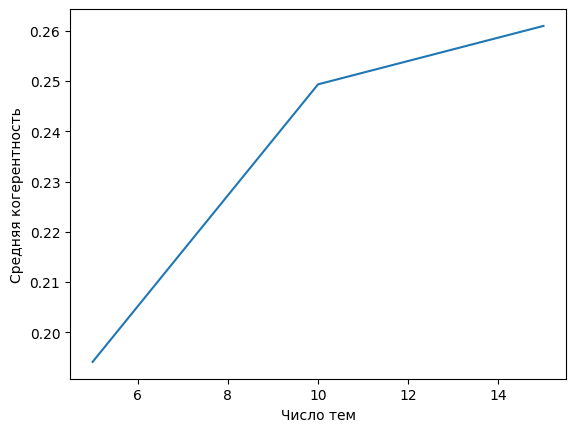

In [120]:
topics_list = [5, 10, 15]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Из графика выше выходит, что 10 - оптимальное число тем. В этом месте наблюдается наибольший перегиб. При увеличении количества тем, когерентность увеличивается незначительно.